# Models - Random Forest and Extra Trees

In [4]:
import pandas as pd

merged = pd.read_csv("../trains_and_weather.csv")
df2 = merged.copy().drop(columns=["categoryCode","categoryCodeId","detailedCategoryCode","detailedCategoryCodeId", "commercialTrack"])


/home/hdheli/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Changing the data to numeric, difference in minutes is used as it is

In [19]:
df3 = df2.copy().sample(2000000)
df3 = df3.astype({'commuterLineID': 'category', 'stationShortCode': 'category'})
categoryToNumeric = df3.select_dtypes(['category']).columns
df3[categoryToNumeric] = df3[categoryToNumeric].apply(lambda x: x.cat.codes)
df3.dtypes

commuterLineID            int8
stationShortCode          int8
differenceInMinutes    float64
weather_area             int64
year                     int64
month                    int64
day                      int64
hour                     int64
direction                int64
rain                   float64
celcius                float64
windGustSpeed          float64
windSpeed              float64
dtype: object

### Save used sample to file

In [20]:
import datetime

now = '../data/samples/'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z.csv'
now
df3.to_csv(now)

### Make the model

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df3.drop("differenceInMinutes", axis=1), df3['differenceInMinutes'],
                                                    train_size=0.80, test_size=0.20, random_state=66)

rf3 = RandomForestClassifier(max_depth=12, random_state=66, n_estimators=100)
rf3.fit(X_train, y_train)
y_predtrain_rf3 = rf3.predict(X_train)

NameError: name 'sklearn' is not defined

In [1]:
import sklearn

train_error_rf3 = sklearn.metrics.zero_one_loss(y_train, y_predtrain_rf3)
y_pred_rf3 = rf3.predict(X_test)
test_error_rf3 = sklearn.metrics.zero_one_loss(y_test, y_pred_rf3)


AttributeError: module 'sklearn' has no attribute 'metrics'

### Plot confusion matrix

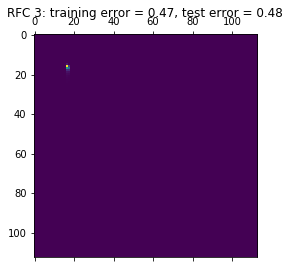

In [24]:
import matplotlib.pyplot as plt

plt.matshow(sklearn.metrics.confusion_matrix(y_test, y_pred_rf3))
plt.title("RFC 3: training error = %.2f, test error = %.2f" % (train_error_rf3, test_error_rf3))
plt.show()

### Save the model

In [25]:
from joblib import dump, load
model_path = '../data/ml-models/rf'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z'

dump(rf3, model_path) 

['../ml-models/rf2020-10-01T13:16:42Z.csv']

### Make another model: ExtraTreesClassifier

Recommeded by Tpot as the Best pipeline: ExtraTreesClassifier(input_matrix, bootstrap=True, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=12, n_estimators=100)
0.7155349051975411

Changing the data to numeric. As the model fitting crashes if minutes are used as they are, I convert them to classes:

0 = (minutes <= 0)
1 = (0 < minutes < 3)
2 = (3 <= minutes < 5)
3 = (5 <= minutes < 10)
4 = (10 <= minutes < 20)
5 = (20 <= minutes < 30)
6 = (30 <= minutes)


In [5]:
# Getting a new sample
df4 = df2.copy().sample(2000000)
df4 = df4.dropna()
df4 = df4.astype({'commuterLineID': 'category', 'stationShortCode': 'category'})
categoryToNumeric = df4.select_dtypes(['category']).columns
df4[categoryToNumeric] = df4[categoryToNumeric].apply(lambda x: x.cat.codes)
df4.dtypes

commuterLineID            int8
stationShortCode          int8
differenceInMinutes    float64
weather_area             int64
year                     int64
month                    int64
day                      int64
hour                     int64
direction                int64
rain                   float64
celcius                float64
windGustSpeed          float64
windSpeed              float64
dtype: object

In [16]:
def minutes_to_classes(minutes):
    if minutes <= 0:
        return 0
    elif ((0 < minutes) & (minutes< 3)):
        return 1
    elif ((3 <= minutes) & (minutes < 5)):
        return 2
    elif ((5 <= minutes) & (minutes < 10)):
        return 3
    elif ((10 <= minutes) & (minutes < 20)):
        return 4
    elif ((20 <= minutes)&(minutes < 30)):
        return 5
    else:
        return 6
        
df4['differenceMinsClasses'] =  df4['differenceInMinutes'].apply(lambda x: minutes_to_classes(x)) 
df4 = df4.drop("differenceInMinutes", axis=1)

In [17]:
import datetime
now = '../data/samples/'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z.csv'
now
df4.to_csv(now)
df4

,commuterLineID,stationShortCode,weather_area,year,month,day,hour,direction,rain,celcius,windGustSpeed,windSpeed,differenceMinsClasses
1745093,2,35,2,2019,12,31,16,0,0.0,0.1,11.6,7.7,0
10355112,7,0,1,2017,12,1,15,0,0.4,-0.3,9.6,5.8,2
6504334,9,63,2,2018,6,18,17,1,0.0,16.9,11.5,7.3,1
7014555,3,60,1,2018,7,11,14,0,0.0,21.7,4.2,2.1,0
1659977,3,31,1,2019,1,29,17,1,0.0,-5.0,5.2,3.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6916025,3,16,1,2017,6,25,5,1,0.0,13.6,5.2,3.4,0
2485120,3,68,1,2019,2,25,14,1,0.0,6.3,11.2,7.2,0
3570650,6,34,1,2019,8,9,15,1,0.0,22.0,5.3,3.4,0
9751403,11,3,1,2018,4,15,13,1,0.0,11.9,5.3,3.9,1


In [18]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

X_train4, X_test4, y_train4, y_test4 = train_test_split(df4.drop("differenceMinsClasses", axis=1), df4['differenceMinsClasses'],
                                                    train_size=0.80, test_size=0.20, random_state=66)
et4 = ExtraTreesClassifier(bootstrap=True, criterion='gini', max_features=0.9000000000000001, min_samples_leaf=5, min_samples_split=12, n_estimators=100)

### Fitting the model

In [19]:
import sklearn

et4.fit(X_train4, y_train4)

ExtraTreesClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None,
                     max_features=0.9000000000000001, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0.0,
                     min_impurity_split=None, min_samples_leaf=5,
                     min_samples_split=12, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=False,
                     random_state=None, verbose=0, warm_start=False)

In [20]:
y_predtrain_et4 = et4.predict(X_train4)

train_error_et4 = sklearn.metrics.zero_one_loss(y_train4, y_predtrain_et4)
y_pred_et4 = et4.predict(X_test4)
test_error_et4 = sklearn.metrics.zero_one_loss(y_test4, y_pred_et4)

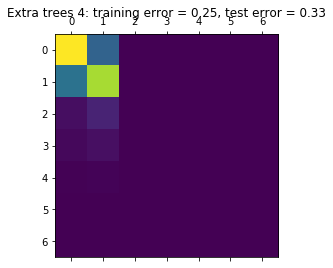

In [21]:
import matplotlib.pyplot as plt

plt.matshow(sklearn.metrics.confusion_matrix(y_test4, y_pred_et4))
plt.title("Extra trees 4: training error = %.2f, test error = %.2f" % (train_error_et4, test_error_et4))
plt.show()

### Save the model

In [22]:
from joblib import dump, load

model_path = '../data/ml-models/et'+str(datetime.datetime.utcnow().isoformat(timespec="seconds"))+'Z'
dump(et4, model_path) 

['../data/ml-models/et2020-10-02T17:26:40Z']